In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
faster_rcnn = FasterRCNNVGG16().cuda()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

In [18]:
%ls ./checkpoints/cars/

baseline_results.pickle                 gt_labels_test.pickle
fasterrcnn_04151829_0.6704369972064141  inv_mahal_cov.pickle
fasterrcnn_04151851_0.6877679369254311  kitti_features.pickle
fasterrcnn_04151914_0.7164561623943497  mahal_cov.pickle
fasterrcnn_04151958_0.7435728692746989  mahal_means.pickle
fasterrcnn_04152043_0.7459420675485349  mahal_result.pickle
fasterrcnn_04152235_0.7462277363985176  pred_bboxes_test.pickle
gt_bboxes_test.pickle                   pred_labels_test.pickle
gt_difficults_test.pickle               pred_scores_test.pickle
gt_labels.pickle                        tsne_features.pickle


In [19]:
trainer.load('./checkpoints/cars/fasterrcnn_04152235_0.7462277363985176')
trainer.faster_rcnn.load_mahalanobis_features(save_dir='./checkpoints/cars')

In [20]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

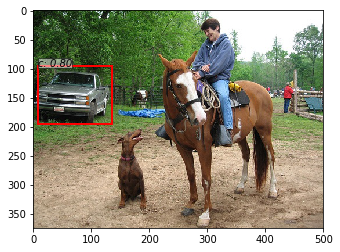

In [21]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

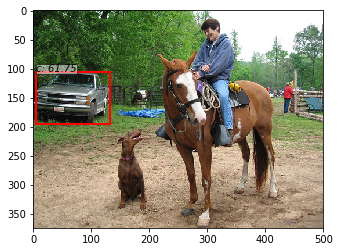

In [22]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

In [23]:
from data.dataset import Dataset, TestDataset, inverse_normalize
from torch.utils import data as data_

opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
testset = TestDataset(opt, split="val")
test_dataloader = data_.DataLoader(testset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False,
                                   pin_memory=True
                                   )

  0%|          | 2/3578 [00:01<46:29,  1.28it/s]


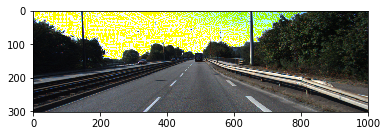

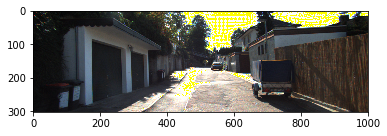

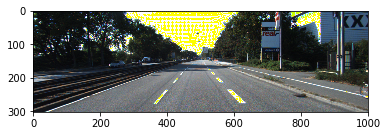

In [24]:
from utils.vis_tool import vis_bbox, vis_image
from tqdm import tqdm
import torch
from utils import array_tool as at

EPSILON=0.005

i = 0
for imgs, sizes, _, _, difficult in tqdm(test_dataloader, total=opt.test_num):    
    _, H, W = imgs.shape[1:]
    o_H, o_W = sizes
    scale = o_H / H
    
#     _bboxes, _labels, _scores = trainer.faster_rcnn.predict(at.totensor(imgs), [[H,W]])
    imgs = trainer.faster_rcnn.input_perturbation(imgs, scale, epsilon=1)
    vis_image(inverse_normalize(at.tonumpy(imgs[0])))
    if i == 2:
        break
    i += 1

# Mahalanobis with input perturbation

In [25]:
from model.utils.bbox_tools import bbox_iou

def iou(bbox, label, gt_boxes, gt_labels, iou_thresh=0.5):
    ious = bbox_iou(np.array([bbox]), gt_boxes)
    best_iou = np.max(ious)
    best_label = gt_labels[np.argmax(ious)]
    
    return best_iou, best_iou > 0 and best_label == label

In [26]:
import matplotlib.pyplot as plt


def generate_mahal_plot(epsilon):
    IOU_THRESH = 0.5
    scores = list()
    ious = list()
    class_corrects = list()
    
    i = 0
    
    for imgs, sizes, gt_bboxes, gt_labels, difficult in tqdm(test_dataloader, total=opt.test_num):    
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict_mahalanobis(imgs, [sizes], perturbation=epsilon)

        #calc iou and class correct
        for pred_bbox, pred_label, pred_score in zip(pred_bboxes[0], pred_labels[0], pred_scores[0]):
            if not len(pred_bbox):
                print('shite')
            best_iou, class_correct = iou(pred_bbox, 
                                          pred_label, 
                                          at.tonumpy(gt_bboxes)[0], 
                                          at.tonumpy(gt_labels)[0], 
                                          iou_thresh=IOU_THRESH)
            scores.append(pred_score)
            ious.append(best_iou)
            class_corrects.append(class_correct)
        
        if i == 200:
            break   # TODO: REMOVE FOR ENTIRE DATASET ITERATION
        i += 1
        
    plt.scatter(scores, ious, c=class_corrects, cmap='viridis', s=5)
    plt.title("Input perturbation = {}".format(epsilon))
    plt.xlabel("Mahalanobis Distance")
    plt.ylabel("IoU with GT")
    plt.show()
    
    return scores, ious, class_correctsscores, ious, class_corrects

In [27]:
epsilons = [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

In [28]:
for eps in epsilons:
    results = generate_mahal_plot(eps)
    
    with open("results_{}.pickle".format(eps), 'wb') as f:
        pickle.dump(results, f)

  1%|▏         | 49/3578 [00:22<27:15,  2.16it/s]

KeyboardInterrupt: 

In [ ]:
from metrics import auroc, barcode_plot

for eps in epsilons:
    with open("results_{}.pickle".format(eps), 'rb') as f:
        scores, ious, class_corrects = pickle.load(f)
        
    plt.scatter(scores, ious, c=class_corrects, cmap='viridis', s=5)
    plt.title("Input perturbation = {}".format(eps))
    plt.xlabel("Mahalanobis Distance")
    plt.ylabel("IoU with GT")
    plt.show()
    
    barcode_plot(scores, class_corrects)
    print("AUROC:", auroc([-1 * s for s in scores], class_corrects))
    print('-'*100)